<a href="https://colab.research.google.com/github/johnberg1/COMP447-547-S22/blob/main/homework3/HW3_GANs_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Blackboard, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In this homework, you will be implementing GANs and diffusion models. 

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

You will be implementing the code using PyTorch. Some parts of the code such as function headers are already provided to you, you will need to fill out the parts with "YOUR CODE HERE". Feel free to create more cells and more functions or modify the existing ones if you wish.

After you complete the assignment, download the specified images outputted in the results/ folder (which you can find on the left dashboard by clicking the folder icon) and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/johnberg1/deepul.git
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 238, done.
remote: Total 238 (delta 0), reused 0 (delta 0), pack-reused 238
Receiving objects: 100% (238/238), 60.56 MiB | 31.90 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Processing ./deepul
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22837 sha256=67293f1d176733ff9c5dfeeb9f48c054707074c843c597c59fef1a7cc723ab50
  Stored in directory: /tmp/pip-ephem-wheel-cache-7beghlnc/wheels/40/86/14/ae5eebf191515af53ab86be6749af0ae2a71269b38f187557d
Successfully built deepul


In [2]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

# Question 1: DCGAN on Emoji Dataset [25 pts]

In the first two questions of this homework, you will be working on emoji datasets. In Q1, you will implement DCGAN on Windows emoji dataset. In Q2, you will implement a CycleGAN between the Windows and Apple emojis.

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from six.moves.urllib.request import urlretrieve
import tarfile

import imageio

### Visualizing the Datasets

The following code will download the datasets and display example emojis from Apple and Windows.

data/emojis.tar.gz
Extracting file.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


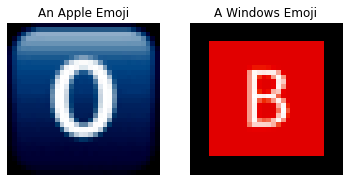

In [4]:
data_fpath = get_file(fname='emojis', 
                         origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz', 
                         untar=True)
_, apple_test_loader = get_emoji_dataloader('Apple')
_, windows_test_loader = get_emoji_dataloader('Windows')
apple_sample = next(iter(apple_test_loader))[0][0].numpy().transpose(1,2,0)
windows_sample = next(iter(windows_test_loader))[0][0].numpy().transpose(1,2,0)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(apple_sample)
ax1.set_title('An Apple Emoji')
ax1.axis('off')

ax2.imshow(windows_sample)
ax2.set_title('A Windows Emoji')
ax2.axis('off')
fig.show()

### Solution
In this part, you need to implement a DCGAN architecture. Let's start with the Generator. The generator starts with a latent vector of size 100 and converts it to a 32x32x3 image. Here is a figure, describing the DCGAN generator:

![](https://drive.google.com/uc?export=view&id=1n3H29xfUHBnNO_rBwAzs2WXAPsIL1A64)


Also, here is a pseudocode for you to follow:

```
DCGenerator
    Linear(100, 128*4*4)
    reshape to B,C,H,W
    BatchNorm2d(128)
    ReLU

    nn.Upsample(2)
    Conv2d(128, 64, 5, stride=1, padding=2, bias=False)
    BatchNorm2d(64)
    ReLU

    nn.Upsample(2)
    Conv2d(64, 32, 5, stride=1, padding=2, bias=False)
    BatchNorm2d(32)
    ReLU

    nn.Upsample(2)
    Conv2d(32, 3, 5, stride=1, padding=2, bias=False)
    tanh

```



In [5]:
class DCGenerator(nn.Module):
    def __init__(self, noise_size=100):
        super(DCGenerator, self).__init__()
        """ YOUR CODE HERE """
        self.layer_1 = torch.nn.Linear(noise_size, 128*4*4)
                  
        layers = [
                  torch.nn.BatchNorm2d(128),
                  torch.nn.ReLU(),

                  torch.nn.Upsample(scale_factor=2),
                  torch.nn.Conv2d(128, 64, 5, stride=1, padding=2, bias=False),
                  torch.nn.BatchNorm2d(64),
                  torch.nn.ReLU(),
                  
                  torch.nn.Upsample(scale_factor=2),
                  torch.nn.Conv2d(64, 32, 5, stride=1, padding=2, bias=False),
                  torch.nn.BatchNorm2d(32),
                  torch.nn.ReLU(),
                  
                  torch.nn.Upsample(scale_factor=2),
                  torch.nn.Conv2d(32, 3, 5, stride=1, padding=2, bias=False),
                  torch.nn.Tanh()
        ]
        self.layers_2 = torch.nn.Sequential(*layers)

    def forward(self, z):
        """ YOUR CODE HERE """
        B, C , H, W = z.shape[0], 128, 4, 4
        out = self.layer_1(z)
        out = out.reshape(B, C, H, W)
        out = self.layers_2(out)
        return out


Let's move on to the Discriminator. The discriminator takes 32x32x3 images and outputs a score for this image. Here is a figure describing the Discriminator architecture:

![](https://drive.google.com/uc?export=view&id=1EB_z2jjGipYvMURHNImbJnQjndpm42yi)

Also, here is a pseudocode for you to follow:


```
DCDiscriminator
    Conv2d(3,64,5, stride=2, padding=2, bias=False)
    BatchNorm2d(64)
    ReLU

    Conv2d(64, 128, 5, stride=2, padding=2, bias=False)
    BatchNorm2d(128)
    ReLU

    Conv2d(128, 256, 5, stride=2, padding=2, bias=False)
    BatchNorm2d(256)
    ReLU

    Conv2d(256,1,5, stride=2, padding=1, bias=False)
    squeeze
```




In [6]:
class DCDiscriminator(nn.Module):
    """Defines the architecture of the discriminator network.
    """
    def __init__(self, conv_dim=64):
        super(DCDiscriminator, self).__init__()
        """ YOUR CODE HERE """
        layers = [
                  torch.nn.Conv2d(3, conv_dim, 5, stride=2, padding=2, bias=False),
                  torch.nn.BatchNorm2d(conv_dim),
                  torch.nn.ReLU(),

                  torch.nn.Conv2d(conv_dim, 128, 5, stride=2, padding=2, bias=False),
                  torch.nn.BatchNorm2d(128),
                  torch.nn.ReLU(),

                  torch.nn.Conv2d(128, 256, 5, stride=2, padding=2, bias=False),
                  torch.nn.BatchNorm2d(256),
                  torch.nn.ReLU(),

                  torch.nn.Conv2d(256, 1, 5, stride=2, padding=1, bias=False),
        ]

        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        """ YOUR CODE HERE """
        out = self.model(x)
        out = out.squeeze(0)
        return out

Now, we are ready to write the training loop. The following cell already contains a function template for you. You will need to complete the necessary parts. Please fill in the parts saying `YOUR CODE HERE` according to the comments above them. Don't forget to return your loss lists in the end.

Use Adam optimizer for both the generator and the discriminator. Use `learning rate = 0.0003` for the generator and `learning rate = 0.0006` for the discriminator. For both optmizers, use `beta1 = 0.3` and `beta2 = 0.999`


Here is a summary for the training procedure, please follow the loss function described here:

![](https://drive.google.com/uc?export=view&id=1HvakN3fNAVDyLbZ0L8ZbNox5GABBU3H8)


In [7]:
def gan_training_loop(G, D, train_loader, test_loader):
    # Create optimizers
    """ YOUR CODE HERE """
    lr_G = 0.0003
    lr_D = 0.0006
    beta1 = 0.3
    beta2 = 0.999

    optim_G = torch.optim.Adam(G.parameters() ,lr_G, (beta1, beta2))
    optim_D = torch.optim.Adam(D.parameters() , lr_D, (beta1, beta2))

    # We created a fixed noise vector, we will use this noise to visualize generated samples
    # throughout the training. 
    fixed_noise = (torch.rand(100, 100) * 2 - 1).cuda()
    iteration = 1
    epochs = 150 

    # Initialize empty lists to hold d_fake, d_real and
    # the generator losses
    """ YOUR CODE HERE """
    # Discriminators's loss for fake samples, Discriminator's loss for real samples, Generator's loss for generated samples
    d_fake, d_real, g_loss = [], [], [] 

    for epoch in range(epochs): 
        for real_images, _ in train_loader:
            real_images = real_images.cuda()

            # Updating the discriminator, here is a pseudocode        
              # call zero grad
              # pass the real images through D
              # calculate d_real loss

              # create 32x100 noise vector
              # generate fake samples
              # pass the fake images through D
              # calculate d_fake loss

              # sum the two losses
              # call backward and take optimizer step
            """ YOUR CODE HERE """
            optim_D.zero_grad()
            pred_D_real = D(real_images)
            loss_D_real = torch.nn.functional.mse_loss(pred_D_real, torch.ones_like(pred_D_real)) / 2

            noise_vec = (torch.rand(32, 100) * 2 - 1).cuda()
            fake_samples = G(noise_vec)
            disc_out = D(fake_samples)
            loss_D_fake = torch.nn.functional.mse_loss(disc_out, torch.zeros_like(disc_out)) / 2

            total_D_loss = loss_D_real + loss_D_fake
            total_D_loss.backward()
            optim_D.step()

             # Updating the generator, here is a pseudocode 
              # call zero grad
              # create 32x100 noise vector
              # generate fake samples
              # pass the fake images through D

              # calculate generator loss
              # call backward and take optimizer step
            """ YOUR CODE HERE """
            optim_G.zero_grad()
            noise_vec = (torch.rand(32, 100) * 2 - 1).cuda()
            fake_samples = G(noise_vec)
            disc_out = D(fake_samples)

            loss_G = torch.nn.functional.mse_loss(disc_out , torch.ones_like(disc_out))
            loss_G.backward()
            optim_G.step()

            
            if iteration % 200 == 0:
                # Append losses to you lists (d_real, d_fake, g_loss)
                # You may also wish to print them here for logging purposes
                """ YOUR CODE HERE """
                d_real.append(loss_D_real.item())
                d_fake.append(loss_D_fake.item())
                g_loss.append(loss_G.item())
                print("[==] iteration: ", iteration, ", d_real: ", d_real[-1], \
                      ", d_fake: ", d_fake[-1], ", g_loss: ", g_loss[-1])

            iteration += 1
        
        # We are sampling using the fixed noise, every 20 epochs
        if epoch % 20 == 0 or epoch+1 == epochs:
            gan_save_samples(G, fixed_noise, epoch)

    # Return the loss lists
    """ YOUR CODE HERE """
    return d_real, d_fake, g_loss

Almost ready to train... We will define a simple function, that creates the dataloaders as well as the models and trains the models using the function you filled above. Please complete the following function, the instructions are given as comments.

In [8]:
from torch._C import Generator
def q1():
    train_loader, test_loader = get_emoji_dataloader('Windows')
    # Initialize the generator
    G = DCGenerator()
    G = G.cuda()
    # Initialize the discriminator
    D = DCDiscriminator()
    D = D.cuda()
    # Pass the models and the dataloaders to the gan_training_loop function that returns the losses
    d_real_loss, d_fake_loss, g_loss = gan_training_loop(G, D, train_loader, test_loader)
    # return d_real_loss, d_fake_loss, g_loss
    return d_real_loss, d_fake_loss, g_loss

### Results

Once you've finished `q1`, execute the cell below to visualize and save your results. **You need to include the initial, intermediate and final results in your latext report as well as the training plots.** Also, include your final losses in the latex template.

Saved temp/q1/samples/sample-000000.png
[==] iteration:  200 , d_real:  0.05083101615309715 , d_fake:  0.007821820676326752 , g_loss:  0.6690932512283325
[==] iteration:  400 , d_real:  0.16853557527065277 , d_fake:  0.03539679944515228 , g_loss:  0.1677882820367813
[==] iteration:  600 , d_real:  0.02842087298631668 , d_fake:  0.013210538774728775 , g_loss:  0.6952990293502808
[==] iteration:  800 , d_real:  0.04985899478197098 , d_fake:  0.09502480179071426 , g_loss:  0.9730185270309448
[==] iteration:  1000 , d_real:  0.026065394282341003 , d_fake:  0.008174031972885132 , g_loss:  0.6907163858413696
[==] iteration:  1200 , d_real:  0.05414670705795288 , d_fake:  0.004384409170597792 , g_loss:  0.7346677184104919
Saved temp/q1/samples/sample-000020.png
[==] iteration:  1400 , d_real:  0.011236295104026794 , d_fake:  0.03099183365702629 , g_loss:  0.987326979637146
[==] iteration:  1600 , d_real:  0.03125084564089775 , d_fake:  0.03478182852268219 , g_loss:  0.7667109966278076
[==] it

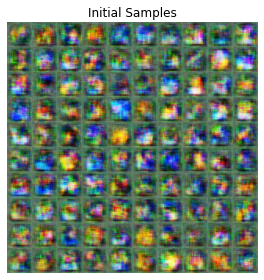

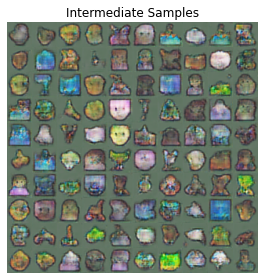

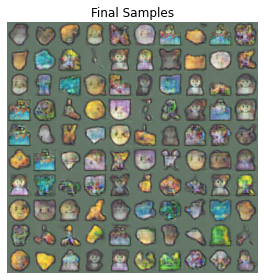

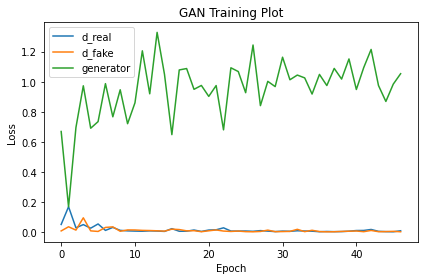

In [9]:
q1_save_results(q1)

Once you have your results, you may execute the following cell to visualize a gif of generated samples throughout the training. You don't need to include this in the report.

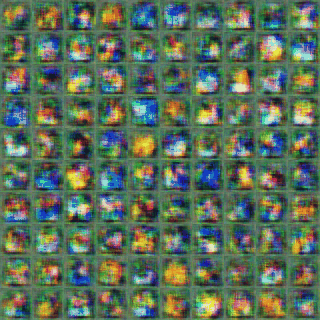

In [10]:
from IPython.display import Image as GIF
GIF(open('temp/q1/samples/anim.gif','rb').read())

 ### <font color='red'> Inline Question 1 </font>

*   Sometimes the original GAN objective is called as the *saturating loss*. Why do you think it is called this way? Is there an alternative loss function? What are the differences of this alternative and how are these differences helping? Please briefly explain.

<font color='green'> My Answers </font>

It is called saturating loss because in practice that loss saturates for the generator when the generated samples are easily classified as fake by the discriminator, and as a result gradients vanish and the generator stops learning if it doesn't catch up with the discriminator. There is an alternative loss function, Non-saturating GAN loss. This loss is a variant of the original GAN objective in which the generator maximizes the log of the discriminant probabilities -log(D(G(z))). As a result of this modification the loss function saturates when the generator is producing outputs that can fool the classifier instead of saturating when the generator is producing outputs that can not fool the classifier as is the case with the original GAN objective. This alternative approach works better since gradients vanish when the generated samples are good and in that case we don't need to update  generator whereas, when the samples are not good the gradients are not vanishing so that we can update the generator to keep it training.

# Question 2: CycleGAN [25 pts]

In this part, you will implement a CycleGAN model that will convert Windows emojis to Apple emojis and the other way around.

### Solution

This will be an image to image translation task. The task of the generator will be to take an image and translate it to another domain. 

The generator in the CycleGAN has layers that implement three stages of computation: 1) the first stage *encodes* the input via a series of convolutional layers that extract the image features; 2) the second stage then *transforms* the features by passing them through one or more *residual blocks*; and 3) the third stage *decodes* the transformed features using a series of transpose convolutional layers, to build an output image of the same size as the input. 

The residual block used in the transformation stage consists of a convolutional layer, where the input is added to the output of the convolution. This is done so that the characteristics of the output image (e.g., the shapes of objects) do not differ too much from the input. Here is a figure summarizing the CycleGAN.

![](https://drive.google.com/uc?export=view&id=1ED3F_E2uuUIFszie0wuHgmUX2wb7Wuy2)


We will start by implementing a ResnetBlock. This will be a very simple one, containing only a convolutional layer and a batch normalization layer. Here is the pseudocode:



```
ResnetBlock
    Conv2d(conv_dim, conv_dim, 3, stride=1, padding=1)
    BatchNorm2d(conv_dim)
    add the input back
```



In [11]:
class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()
        """ YOUR CODE HERE """
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(conv_dim, conv_dim, 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(conv_dim)
            )

    def forward(self, x):
        """ YOUR CODE HERE """
        out = self.model(x)
        out = out + x # Residual connection
        return out

Now, we can implement the generator. As discussed above, the generator will consist of 3 parts. Here is a pseudocode for the generator network:


```
# Encoding
Conv2d(3, 64, 5, stride=2, padding=2, bias=False)
BatchNorm2d(64)
ReLU
Conv2d(64, 128, 5, stride=2, padding=2, bias=False)
BatchNorm2d(128)
ReLU

# Transforming
ResnetBlock(128)
ReLU

# Decoding
nn.Upsample(2)
Conv2d(128, 64, 5, stride=1, padding=2, bias=False)
BatchNorm2d(64)
ReLU
nn.Upsample(2)
Conv2d(64, 3, 5, stride=1, padding=2, bias=False)
tanh
```



In [12]:
class CycleGenerator(nn.Module):
    """Defines the architecture of the generator network.
       Note: Both generators G_XtoY and G_YtoX have the same architecture in this assignment.
    """
    def __init__(self,):
        super(CycleGenerator, self).__init__()
        """ YOUR CODE HERE """
        # 1. Define the encoder part of the generator (that extracts features from the input image)
        encoder_layers = [
                          torch.nn.Conv2d(3, 64, 5, stride=2, padding=2, bias=False),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.ReLU(),
                          torch.nn.Conv2d(64, 128, 5, stride=2, padding=2, bias=False),
                          torch.nn.BatchNorm2d(128),
                          torch.nn.ReLU()           
        ]
        self.encoder_model = torch.nn.Sequential(*encoder_layers)
        
        # 2. Define the transformation part of the generator
        transformation_layers = [
                          ResnetBlock(128),
                          torch.nn.ReLU()
        ]
        self.transformation_model = torch.nn.Sequential(*transformation_layers)
        
        # 3. Define the decoder part of the generator (that builds up the output image from features)
        generator_layers = [
                          nn.Upsample(scale_factor=2),
                          torch.nn.Conv2d(128, 64, 5, stride=1, padding=2, bias=False),
                          torch.nn.BatchNorm2d(64),
                          torch.nn.ReLU(),
                          torch.nn.Upsample(scale_factor=2),
                          torch.nn.Conv2d(64, 3, 5, stride=1, padding=2, bias=False),
                          torch.nn.Tanh()
        ]
        self.generator_model = torch.nn.Sequential(*generator_layers)
    
    def forward(self,x):
        """ YOUR CODE HERE """
        out = self.encoder_model(x)
        out = self.transformation_model(out)
        out = self.generator_model(out)
        return out


For the discriminators, you will use your implementation from the first question. We will use the same Generator model for `G_XtoY` and `G_YtoX` and the same Discriminator model for `D_X` and `D_Y`.

We are ready to write the training loop. Again, the following cell already contains a function template for you. You will need to complete the necessary parts. Please fill in the parts saying `YOUR CODE HERE` according to the comments above them. Don't forget to return your loss lists in the end.

Use a single optimizer for the two generators and a single optimizer for the two discriminators. Use Adam optimizer, `learning rate = 0.0003` and `beta1 = 0.3` and `beta2 = 0.999` for both optimizers.

Here is a summary of the training procedure:

![](https://drive.google.com/uc?export=view&id=1XB0hM6vyM9QkjDHQVzjhDeVu0S-tLrlm)



In [13]:
def cyclegan_training_loop(G_XtoY, G_YtoX, D_X, D_Y, dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y):
    # Create optimizers as discussed above
    """ YOUR CODE HERE """
    lr = 0.0003
    beta1 = 0.3
    beta2 = 0.999

    optim_G_XtoY = torch.optim.Adam(G_XtoY.parameters(), lr, (beta1,beta2))
    optim_G_YtoX = torch.optim.Adam(G_YtoX.parameters(), lr, (beta1,beta2))
    optim_D_X = torch.optim.Adam(D_X.parameters(), lr, (beta1,beta2))
    optim_D_Y = torch.optim.Adam(D_Y.parameters(), lr, (beta1,beta2))

    # Data iterators are created
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # We will again keep some fixed inputs to visualize throughout training
    fixed_X = (test_iter_X.next()[0]).cuda()
    fixed_Y = (test_iter_Y.next()[0]).cuda()

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    iteration = 1
    iter_per_epoch = min(len(iter_X), len(iter_Y))
    epochs = 50 

    # Initialize empty lists to hold d_fake, d_real and
    # the generator losses
    """ YOUR CODE HERE """
    # Discriminator's fake loss, Discriminator's real loss, Generator's loss
    d_fake, d_real, g_loss = [], [], [] 

    for epoch in range(epochs):
        iter_X = iter(dataloader_X)
        iter_Y = iter(dataloader_Y)
        for itr in range(iter_per_epoch):
            images_X, _ = iter_X.next()
            images_X = images_X.cuda()
            
            images_Y, _ = iter_Y.next()
            images_Y = images_Y.cuda()

            # ============================================
            #            TRAIN THE DISCRIMINATORS
            # ============================================
            
            # Here, you need to update the discriminators, here is a pseudocode
              # Step 1: real
              # call zero grad

              # pass the real X images through D_X
              # calculate the D_X real loss
              
              # pass the real Y images through D_Y
              # calculate the D_Y real loss
              
              # total real loss is sum of the two
              # backward
              # take optimizer step


              # Step 2: fake
              # call zero grad
              
              # pass the real images Y through G_YtoX to get fake X images
              # pass the fake X images through D_X
              # calculate D_X fake loss
              
              # pass the real images X through G_XtoY to get fake Y images
              # pass the fake Y images through D_Y
              # calculate D_Y fake loss
              
              # total fake loss is sum of the two
              # backward
              # take optimizer step
            """ YOUR CODE HERE """
            # step 1: real
            optim_D_X.zero_grad()
            optim_D_Y.zero_grad()

            out_D_X_real = D_X(images_X)
            loss_D_X_real = torch.nn.functional.mse_loss(out_D_X_real, torch.ones_like(out_D_X_real))

            out_D_Y_real = D_Y(images_Y)
            loss_D_Y_real = torch.nn.functional.mse_loss(out_D_Y_real, torch.ones_like(out_D_Y_real))
            
            loss_total_D_real = loss_D_X_real + loss_D_Y_real
            loss_total_D_real.backward()
            optim_D_X.step()
            optim_D_Y.step()


            # step 2: fake
            optim_D_X.zero_grad()
            optim_D_Y.zero_grad()

            fake_X = G_YtoX(images_Y)
            loss_D_Y_fake = torch.nn.functional.mse_loss(fake_X, torch.zeros_like(fake_X))

            fake_Y = G_XtoY(images_X)
            loss_D_X_fake = torch.nn.functional.mse_loss(fake_Y, torch.zeros_like(fake_Y))

            loss_total_D_fake = loss_D_Y_fake + loss_D_X_fake
            loss_total_D_fake.backward()
            optim_D_X.step()
            optim_D_Y.step()

            
            # =========================================
            #            TRAIN THE GENERATORS
            # =========================================

            # Here, you need to update the discriminators, here is a pseudocode
              # Step 1: Y -> X -> Y
              # call zero grad
              
              # pass the real images Y through G_YtoX to get fake X images
              # pass the fake X images through D_X
              # calculate g_loss
              
              # pass the fake X images through G_XtoY to reconstruct Y images
              # calculate consistency loss between real Y images and reconstructed ones (mean absolute error)
              
              # with 0.015 multiplier, add the cycle consistency loss to g_real 
              # backward g_loss
              # take optimizer step


              # Step 2: X -> Y -> X
              # call zero grad
              
              # pass the real images X through G_XtoY to get fake Y images
              # pass the fake Y images through D_Y
              # calculate g_loss
              
              # pass the fake Y images through G_YtoX to reconstruct X images
              # calculate consistency loss between real Y images and reconstructed ones (mean absolute error)
              
              # with 0.015 multiplier, add the cycle consistency loss to g_real 
              # backward g_loss
              # take optimizer step
            """ YOUR CODE HERE """
            # step 1: Y -> X -> Y
            optim_G_XtoY.zero_grad()
            optim_G_YtoX.zero_grad()

            fake_X = G_YtoX(images_Y)
            out_D_X_fake = D_X(fake_X)
            loss_G_X = torch.nn.functional.mse_loss(out_D_X_fake, torch.ones_like(out_D_X_fake))
            
            out_reconstructed_Y = G_XtoY(fake_X)
            # consistency_loss_reconstructed_Y = torch.nn.functional.mse_loss(out_reconstructed_Y, images_Y)
            consistency_loss_reconstructed_Y = torch.mean(torch.sum(torch.sum(torch.sum(torch.abs(out_reconstructed_Y - images_Y), dim=1),dim=1), dim=1))
            
            total_loss_G_X = loss_G_X + (0.015 * consistency_loss_reconstructed_Y)
            total_loss_G_X.backward()
            optim_G_YtoX.step()
            optim_G_XtoY.step()


            # step 2: X -> Y -> X
            optim_G_XtoY.zero_grad()
            optim_G_YtoX.zero_grad()

            fake_Y = G_XtoY(images_X)
            out_D_Y_fake = D_Y(fake_Y)
            loss_G_Y = torch.nn.functional.mse_loss(out_D_Y_fake, torch.ones_like(out_D_Y_fake))

            out_reconstructed_X = G_YtoX(fake_Y)
            consistency_loss_reconstructed_X = torch.nn.functional.mse_loss(out_reconstructed_X, images_X)

            total_loss_G_Y = loss_G_Y + (0.015 * consistency_loss_reconstructed_X)
            total_loss_G_Y.backward()
            optim_G_XtoY.step()
            optim_G_YtoX.step()



            if iteration % 200 == 0:
                # Append losses to you lists (d_real, d_fake, g_loss)
                # You may also wish to print them here for logging purposes
                """ YOUR CODE HERE """
                d_real.append(loss_total_D_real.item())
                d_fake.append(loss_total_D_fake.item())
                g_loss.append(total_loss_G_Y.item() + total_loss_G_X.item())
                print("[==] iteration: ", iteration, ", d_real: ", d_real[-1], \
                      ", d_fake: ", d_fake[-1], ", g_loss: ", g_loss[-1])

            iteration += 1

        # We are getting samples from the fixed inputs, every 10 epochs 
        if epoch % 10 == 0 or epoch+1 == epochs:
            cyclegan_save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY)
            
    # Return the loss lists
    """ YOUR CODE HERE """
    return d_real, d_fake, g_loss

Now, we will define a simple function, that creates the dataloaders as well as the models and trains the models using the function you filled above. Please complete the following function, the instructions are given as comments.

In [14]:
def q2():
    x_train_loader, x_test_loader = get_emoji_dataloader('Windows')
    y_train_loader, y_test_loader = get_emoji_dataloader('Apple')
    # initialize G_XtoY, G_YtoX, D_X and D_Y
    G_XtoY = CycleGenerator()
    G_YtoX = CycleGenerator()
    D_X = DCDiscriminator()
    D_Y = DCDiscriminator()

    G_XtoY = G_XtoY.cuda()
    G_YtoX = G_YtoX.cuda()
    D_X = D_X.cuda()
    D_Y = D_Y.cuda()
    # Pass the models and the dataloaders to the cyclegan_training_loop function that returns the losses
    d_real, d_fake, g_loss = cyclegan_training_loop(G_XtoY, G_YtoX, D_X, D_Y, x_train_loader, y_train_loader, x_test_loader, y_test_loader)
    # return d_real_loss, d_fake_loss, g_loss
    return d_real, d_fake, g_loss

### Results

Once you've finished `q2`, execute the cell below to visualize and save your results. **You need to include the initial, intermediate and final results in your latext report as well as the training plots.** Also, include your final losses in the latex template.

Saved temp/q2/samples/sample-000000-X-Y.png
Saved temp/q2/samples/sample-000000-Y-X.png
[==] iteration:  200 , d_real:  0.053177736699581146 , d_fake:  0.4751282334327698 , g_loss:  6.977093696594238
[==] iteration:  400 , d_real:  0.038378335535526276 , d_fake:  0.4817255139350891 , g_loss:  4.715721283107996
[==] iteration:  600 , d_real:  0.0372563973069191 , d_fake:  0.46866118907928467 , g_loss:  5.4566999496892095
Saved temp/q2/samples/sample-000010-X-Y.png
Saved temp/q2/samples/sample-000010-Y-X.png
[==] iteration:  800 , d_real:  0.1119672879576683 , d_fake:  0.4615890383720398 , g_loss:  4.728652596473694
[==] iteration:  1000 , d_real:  0.10389355570077896 , d_fake:  0.46435654163360596 , g_loss:  4.570103943347931
[==] iteration:  1200 , d_real:  0.004721125587821007 , d_fake:  0.4479740262031555 , g_loss:  4.8812843188643456
Saved temp/q2/samples/sample-000020-X-Y.png
Saved temp/q2/samples/sample-000020-Y-X.png
[==] iteration:  1400 , d_real:  0.023023933172225952 , d_fake:

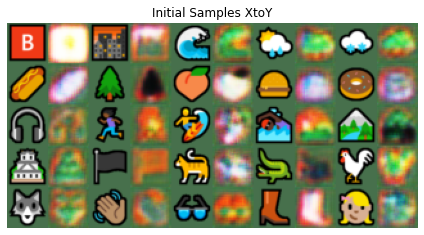

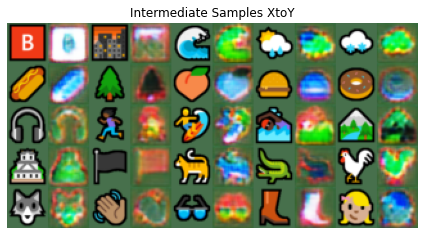

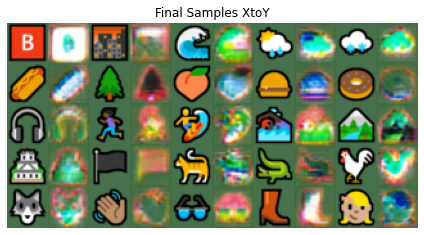

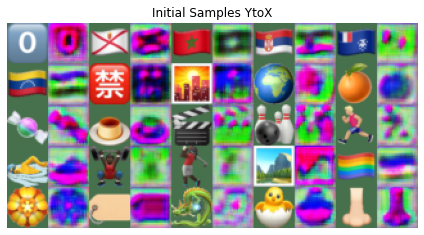

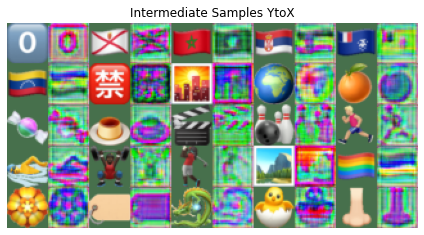

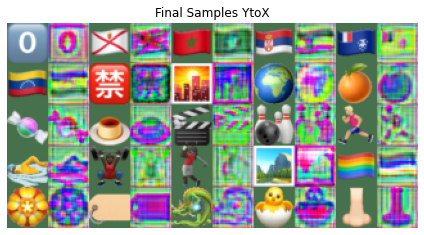

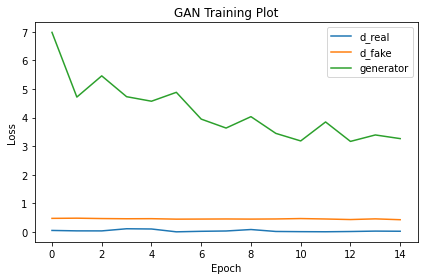

In [15]:
q2_save_results(q2)

Once you have your results, you may execute the following cells to visualize gifs of original emojis and reconstructed versions from your model. You don't need to include these in the report.

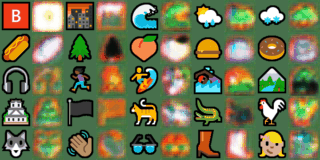

In [16]:
GIF(open('temp/q2/samples/anim_X-Y.gif','rb').read())

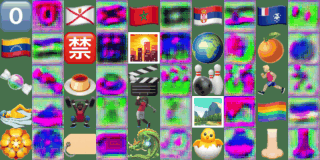

In [17]:
GIF(open('temp/q2/samples/anim_Y-X.gif','rb').read())

 ### <font color='red'> Inline Question 2 </font>

*   Mode Collapse is a common issue with training GANs. Please briefly explain what mode collapse is, when it happens and what are some possible ways to avoid it.

<font color='green'> My Answers </font>
Mode collapse happens when the generator can produce only a small subset of possible outputs which are usually very similar. It occurs due to Generator and Discriminator overfitting to exploit the short term weakness of the other which turns into a cat and mouse game which leads to model not converging. Carefully tuning the learning rate, training for longer epochs and using different loss functions (such as WGAN's loss function) could be used to avoid this problem.

# Question 3: Diffusion-based Deep Generative Models (DDGM)

In this question, we will implement different variants of DDGM. 
As we have learnt in the lecture, DDGM works by gradually applying a diffusion process on the input(e.g adding a Gaussian diffusion) for T different steps and learns the reverse of this diffusion at each step t $\in$ {1, 2, .. , T} as a function $F_{t_{\theta}}$ parameterized by a neural network. We will implement this model in two different ways!

## Part (A): Diffusion Probabilistic Models (DPM) on Low-Res MNIST Dataset [25 pts]
In this part, we will use a diffusion probabilistic model to generate samples of low-resolution MNIST digits dataset.

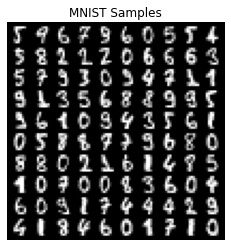

In [18]:
visualize_low_res_mnist()

**DPM forward and reverse diffusion process is defined as:**
```
diffusion(x)
  foreach beta in variance_scheduler:
    x = sqrt(1-beta) x + sqrt(beta) * noise(0, 1)

reverse_diffusion(z)
  foreach network in denoising_networks:
    mean, log_var = network(z)
    z = sample_normal(mean, exp(log_var))
  x = out_network(z)
```

**Construct the DPM with the following specifications** 
- Model every diffusion step t with a separate function $f_{t_\theta}$ parameterized with a multi-layer perceptron with three hidden layers. 
    - Hint: For each dimension of your input, you should predict two numbers (mean and log variance). That is, the output of your denoising function $f_{t_\theta}$ should be 2 * D, where D is the number of dimensions of your input
- Use a fixed variance schedule $\beta$ that starts with value $\beta_1$ and linearly increases towards $\beta_2$ throughout the T diffusion steps. We assume that the covariance matrix is the identiy matrix $I$
    - Hint: You can use reparameterization trick to add noise to your input: $x_{t+1} = \sqrt{1-\beta_{t}} * x_{t} + \sqrt{\beta_{t}} * z_t;$ where $(z_t \sim N(0, 1))$ although $\beta$ is not learnable
- Use an additional MLP layer (out_network) after the last denoising layer before returning the results
- The objective of DPM is maximizing the ELBO. You can think of the diffusion steps as multiple intermediate VAEs. Therefore the ELBO objective is defined as: <br>
    $L_{ELBO} = L_{T} + L_{T-1} + L_{T-2} + \dots + L_{0}$ <br>
    Where: <br>
    $L_{T} = KL(q_{T_\phi}(X_{T}|X_{0}) || p_{T_\theta}(X_T))$ <br>
    $L_{t} = KL(q_{t_\phi}(X_{t}|X_{t+1} )|| p_{t_\theta}(X_t | X_{t-1}))$ for 1 <= t < T <br>
    $L_0 = -\log p_{\theta}(X_0 | X_1)$ <br>
    Where p represents the distribution of the forward diffusion process, and q represents the distribution of the reverse diffusion process. <br>
    **Notice the followings in the objective:**
    - p and q can be both gaussian distributions. The parameters of $p_{t_\theta}$ are fixed $(\sqrt{1-\beta_{t}} X_{t}, \beta)$ and the parameters of q are learned. The KL divergence can be estimated as $KL(q||p) = \frac{1}{N} \sum_{i=1}^{N} log(p(x_i)) - log(q(x_i))$
    - $L_T$ is a constant term and therefore can be dropped for the optimization purposes
    - $L_0$ is the same as the reconstuction loss: $- \log p(\text{out_network}(X_1) - X_0)$ where p is a normal standard distribution
    





**The following hyperparameters are suggested for obtaining minimum results:**
- Number of denoising steps (T) : 10
- Variance schedule : (0.2 -> 0.6).
- Hidden dimensions: 256
- LR: 1e-3
- Epochs: 50


**You will provide the following deliverables**
1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained DPM

For more details, please refer to (Sohl-Dickstein et al) Deep unsupervised learning using nonequilibrium thermodynamics
    

In [19]:
# the following helper functions are given to you
PI = torch.from_numpy(np.asarray(np.pi))

def log_normal_diag(x, mu, log_var):
    """
    calculate p(x) of a normal disturbution with parameters (mu, exp(log_var))
    """
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    return log_p
    
def log_standard_normal(x):
    """
    calculate p(x) of a normal disturbution with parameters (mu, exp(log_var))
    """
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * x**2.
    return log_p

In [20]:
class DPM(nn.Module):
    def __init__(self, denoising_networks, out_network, D, steps, betas):
        super().__init__()
        """ YOUR CODE HERE """ 
        self.denoising_networks = denoising_networks
        self.out_network = out_network
        self.D = D
        self.steps = steps
        self.betas = betas

        # use GPU if available
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.betas = self.betas.to(self.device)
        for i, net in enumerate(self.denoising_networks):
          self.denoising_networks[i] = net.to(self.device)
        self.out_network = self.out_network.to(self.device)

        # initialize optimizers
        lr = 1e-3
        self.optim_denoising_nets = [torch.optim.Adam(self.denoising_networks[i].parameters(), lr) for i in range(len(self.denoising_networks))]
        self.optim_out_network = torch.optim.Adam(self.out_network.parameters(), lr)
      

    """ YOUR CODE HERE """ 
    def diffusion(self, x):
      """
      Returns the final output of the diffusion z, and x_list which is a
      list containing the x values at different time steps.
      """
      # foreach beta in variance_scheduler:
        # x = sqrt(1-beta) x + sqrt(beta) * noise(0, 1)
      x_list = [x]
      for beta in self.betas:
        x = ((1-beta) ** (1/2)) * x + (beta ** (1/2)) * torch.randn(*x.shape).to(self.device)
        x_list.append(x)
      return x, x_list

    def reverse_diffusion(self, z):
      """
      Returns the final output of the reverse diffusion x, and z_list which is a
      list containing the z values at different time steps.
      """
      # foreach network in denoising_networks:
        # mean, log_var = network(z)
        # z = sample_normal(mean, exp(log_var))
      # x = out_network(z)
      z_list = [z]
      param_list = []
      param_dict = []
      for network in self.denoising_networks:
        z = z.to(self.device)
        mean, log_var = network(z).chunk(2, dim=1)
        z = torch.randn(*z.shape).to(self.device) * torch.exp(log_var) + mean
        z_list.append(z)
        param_list.append([mean, log_var])
      x = self.out_network(z)
      z_list.append(x)
      return x, z_list, param_list

    def sample(self, num_samples):
      """
      returns num_samples many generated samples
      """
      z = torch.randn(num_samples, 64)
      out, _, _ = self.reverse_diffusion(z)
      return out

    def train_batch(self, data_batch, mode="train"):
      """
      Trains the network given a batch of samples
      """
      # zero gradients
      if mode == "train":
        for net_denoise in self.optim_denoising_nets:
          net_denoise.zero_grad()
        self.optim_out_network.zero_grad()

      z, z_list = self.diffusion(data_batch)
      x, x_list, param_list = self.reverse_diffusion(z)
      # calculate ELBO loss
      L_t = 0
      L_0 = 0

      # calculate L_t for [1 <= t < T]
      for t in range(1, self.steps - 1): # t = [1, T]
        cur_z = z_list[t] # z_t --> [X_0, X_1, ... X_T]
        cur_z2 = z_list[t-1] # z_t-1
        cur_x = list(reversed(x_list))[t+1] # x_t+1 --> reversed([X_T -> X_T-1, ...,X_2 -> X_1])
        cur_beta = self.betas[t-1]
        # cur_denoising_network = list(reversed(self.denoising_networks))[t] # --> reversed([T-> T-1, ..., 1])

        # calculate L_t
        q_theta = log_normal_diag(cur_z, torch.sqrt(1 - cur_beta)* cur_z2, torch.log(cur_beta))
        # cur_mean, cur_log_var = cur_denoising_network(cur_x).chunk(2, dim=1)
        cur_mean, cur_log_var = list(reversed(param_list))[t-1] # --> reversed([T-> T-1, ..., X_2 -> X_1])
        p_theta = log_normal_diag(cur_x, cur_mean, cur_log_var) 
        L_t += torch.mean(q_theta - p_theta) # calculate average over the batch
      
      # L_t /= (self.steps-1) # calculate average over the diffusion steps
      
      # calculate L_0
      L_0 -= torch.mean(log_standard_normal(x_list[-1] - z_list[0]))

      # total loss/ ELBO
      total_loss = L_0 + L_t
      
      if mode == "train":
        total_loss.backward()
      # Backprop
      if mode == "train":
        for net_denoise in self.optim_denoising_nets:
          net_denoise.step()
        self.optim_out_network.step()
        
      return total_loss, L_0, L_t # ELBO loss, reconstruction loss, sum of KL losses


In [21]:
def q3_a(train_data, test_data, part):
    """
    train_data: An (n_train, 64) numpy array of floats of 8x8 MNIST digits being flattend and normalized between 0-1
    test_data: An (n_test, 64) numpy array of floats of 8x8 MNIST digits being flattend and normalized between 0-1

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and sum of the KL terms evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 8, 8, 1) numpy array of 10 samples from your DDGM with values in {0, ..., 255}
    """

    train_loader = torch.utils.data.DataLoader(2 * train_data - 1, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(2 * test_data -1 , batch_size=128)

    """ YOUR CODE HERE """ 
    batch_losses = []
    test_losses = []
    # hyper_parameters
    steps = 10
    betas = torch.tensor([0.2, 0.24, 0.28, 0.32, 0.36, 0.40, 0.44, 0.48, 0.52, 0.60])
    hidden_dim = 256
    epochs = 50
    D = 64

    # initialize models
    denoising_networks = [ torch.nn.Sequential(
        torch.nn.Linear(64, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 2*D)
    ) for i in range(steps - 1)]

    out_network = torch.nn.Sequential(
        torch.nn.Linear(64, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 64),
        torch.nn.ReLU(), # guarantees outputs are in range [0, 1]
    )

    diffusion_model = DPM(denoising_networks, out_network, hidden_dim, steps, betas)

    # initialize optimizers
    #optim_denoising_nets = [torch.optim.SGD(denoising_networks[i].parameters(), lr) for i in range(len(denoising_networks))]
    # optim_out_network = torch.optim.SGD(out_network.parameters(), lr)
    #optim_diffusion_model = torch.optim.SGD(diffusion_model.parameters(), lr)


    # initially evaluate the model
    with torch.no_grad():
      test_total_loss, test_L_0, test_L_t = 0, 0, 0
      for data in test_loader:
        # use GPU if available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        data = data.to(device)
        diffusion_model = diffusion_model.to(device)
        diffusion_model.eval()

        # calculate losses
        cur_total_loss, cur_L_0, cur_L_t = diffusion_model.train_batch(data, mode="eval")
        # record_batch losses (total)
        test_total_loss += (cur_total_loss.item() * len(data)) 
        test_L_0 += (cur_L_0.item() * len(data))
        test_L_t += (cur_L_t.item() * len(data))
      
      # record per epoch test losses (calculate mean losses from recorded summed/total losses)
      test_losses.append((
          test_total_loss / len(test_loader.dataset),
          test_L_0 / len(test_loader.dataset),
          test_L_t / len(test_loader.dataset)
      ))


    for i in range(epochs):
      for data in train_loader:
        # use GPU if available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        data = data.to(device)
        diffusion_model = diffusion_model.to(device)
        diffusion_model.train()

        # calculate losses
        cur_total_loss, cur_L_0, cur_L_t = diffusion_model.train_batch(data, mode="train")
        
        # record_batch losses (total)
        cur_total_loss += torch.mean(cur_total_loss) 
        cur_L_0 += torch.mean(cur_L_0) 
        cur_L_t += torch.mean(cur_L_t)
        
        # record batch losses
        batch_losses.append((cur_total_loss.cpu().detach().numpy(), cur_L_0.cpu().detach().numpy(), cur_L_t.cpu().detach().numpy()))

      

      # evaluate model
      with torch.no_grad():
        test_total_loss, test_L_0, test_L_t = 0, 0, 0
        for data in test_loader:
          # use GPU if available
          device = "cuda" if torch.cuda.is_available() else "cpu"
          data = data.to(device)
          diffusion_model = diffusion_model.to(device)
          diffusion_model.eval()

          # calculate losses
          cur_total_loss, cur_L_0, cur_L_t = diffusion_model.train_batch(data, mode="eval")
          # record_batch losses (total)
          test_total_loss += (torch.mean(cur_total_loss).item() * len(data)) 
          test_L_0 += (cur_L_0.item() * len(data))
          test_L_t += (cur_L_t.item() * len(data))
        
        # record per epoch test losses (calculate mean losses from recorded summed/total losses)
        test_losses.append((
            test_total_loss / len(test_loader.dataset),
            test_L_0 / len(test_loader.dataset),
            test_L_t / len(test_loader.dataset)
        ))

    
    # generate samples
    with torch.no_grad():
      num_samples = 100
      samples = diffusion_model.sample(num_samples) # Note that samples are normalized like the inputs
      samples = (samples * 255).type(torch.float32).detach().cpu()
      samples = samples.view(num_samples, 8, 8).unsqueeze(-1)
    
    return np.asarray(batch_losses), np.asarray(test_losses), samples

Final -ELBO: -16.2080, Recon Loss: 1.2686, KL Loss: -17.4766


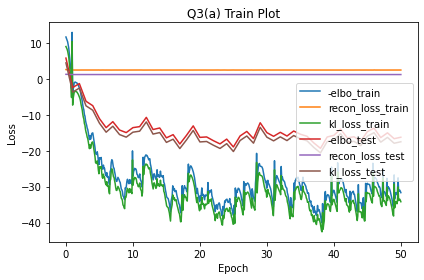

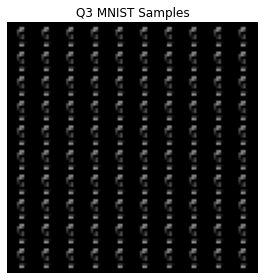

In [22]:
q3_save_results('a', q3_a)

### <font color='red'> Inline Question 3 </font>

*   How does noise parameter $\beta$ and number of diffusion steps (T) affect the diffusion process? 
*   When decreasing the number of steps (T), should we increase or decrease the value of $\beta$ and why? 
*  Lastly, what is the drawback of increasing the number of diffusion steps (T).

<font color='Green'> My Answers </font>
* Noise parameter determines the amount of noise that will be used to distort the image through the diffusion steps. By using higher number of diffusion steps (T), one converges more towards the gaussian noise.

* We should increase the value of $\beta$ since we would have distort the images more with noise to have them converge closer towards the perfect Gaussian noise in a smaller amount of diffusion steps.

* When using DPMs, we will have to iterate through more diffusion steps both when training and sampling therefore it would have higher computational and time cost. 


## Part B) Diffusion Denosing Generative Models [25 pts]
implementing DDGM on Fashion MNIST dataset

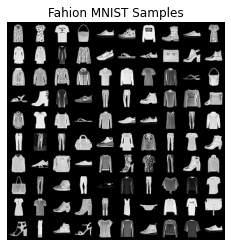

In [ ]:
visualize_fashion_mnist()

**Observe the following shortcomings in the implementation of Part A**:
- **Having separate networks for each reverse diffusion step**:
    this results in high and inefficient memory usage. Alternatively, we can use a single neural network for all of the reverse diffusion steps that is conditioned on the denoising step t. In order to condition the neural network on t, we add the position encoding of t to the input of the neural network $x_t$.
    
- **Traversing all of the diffusion steps on every training iteration**: this would require backpropagating through all of the diffusion steps at each training step which would limit the maximum number of steps that we can use.
Considering the diffusion process mentioned in part (A) and assuming that $\alpha_t = 1 - \beta_t$ we can derive that:<br>
$x_{t+1} = \sqrt{\alpha_{t}} * x_{t} + \sqrt{1 - \alpha_{t}} * z_t;$ where $(z_t \sim N(0, 1))$ <br>
$x_{t+1} = \sqrt{\alpha_{t} \alpha_{t-1}} * x_{t-1} + \sqrt{1 - \alpha_{t} \alpha_{t-1}} * \bar{z}_{t-2}$; where ($\bar{z}_{t-2}$ merges two gaussians) <br>
$x_{t+1} = \sqrt{\bar{\alpha}_{t}} * x_{0} + \sqrt{1 - \bar{\alpha}_{t}} * z;$ where $(z \sim N(0, 1))$ and $\bar{\alpha}_{t} = \Pi_{i=1}^{t} \alpha_{i}$

    This reparameterization is very useful for efficient optimization. As calculating $X_t$ no longer requires calculated the intermediate latents $X_{t-1}, X_{t-2} ...$, we can now sample step $t \sim {\{1, 2, \dots T\}}$ at each training step, calculate $X_t$ and optimize accordingly without having to do the forward and backwared diffusion process for all steps T. 

In this part, we aim to overcome these two shortcomings by implementing the suggested solutions above
   
**Construct the DPM with the following specifications**
- Fixed variance schedule that increases linearly $\beta (1e-4, 0.02)$
- Model the reverse diffusion step with a UNet architecture conditioned on the reverse diffusion step t. 
- Add positional encoding of the diffusion step $t$ to every layer in the Unet by repeating the position embeddings of size $C$ for $D\times D$ times and adding it to the output of that layer $Z_t$ Where $C \times D\times D$ is the output dimension of that layer ($Z_t$)
- The objective for DDGM is quit simpler than part(A) and defined as: <br>
    $L_t = \mathbb{E}_{\mathbf{x}_0, \mathbf{z}_t} \Big[\|\mathbf{z}_t - \mathbf{z}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\mathbf{z}_t, t)\|^2 \Big]$ <br>
    where $z_t$ is the sampled noise from the normal distribution and $z_\theta$ is a neural network that predicts the sampled noise. That means that the objective is defined as the L2 loss between the sampled noise and the predicted noise (to be removed) by the neural netowork $z_\theta$. For more details about the objective and its derivations, please refer to (Ho et al.) Denoising Diffusion Probabilistic Models.
   
- Use the following training and sampling algorithms: 
![Image](https://i.ibb.co/cxSpCsS/DDPM-algo.png)


**Positional Encoding:**

Use the Transformer positional encoding in your DDGM [(Reference)](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)

You might find the following pseudocode helpful:
```
pos_encoding(t):
  w = 1 / 1000 ^ (range(0, C, 2) / C)
  p[:, 0::2] = sin(t.repeat(1, C)[:, 0::2])
  p[:, 1::2] = cos(t.repeat(1, C)[:, 1::2])
  return p.repeat(1, 1, D, D)
```

**The following Unet architecture is suggested for modeling the reverse diffusion process:** <br>
```
    // downsampling 
    x <- relu(conv2d(1, 64, 3)(x)) # 32 x 32
    x1 <- relu(downsample(x)) # 16 x 16
    x1 <- relu(ResnetBlock(64, 64)(x1)) 
    x1 <- relu(conv2d(64, 128)(x1)) + pos_encoding(t)

    x2 <- relu(downsample(x1)) # 8 x 8  
    x2 <- relu(ResnetBlock(128, 128)(x2)) 
    x2 <- relu(conv2d(128, 256)(x2)) + pos_encoding(t)

    x3 <- relu(downsample(x2)) # 4 x 4
    x3 <- relu(ResnetBlock(256, 256)(x3))
    x3 <- relu(conv2d(256, 512)(x3)) + pos_encoding(t)
    
    // upsampling 
    x4 <- relu(upsample(x3)) # 8 x 8
    x4 <- relu(conv2d(512, 256)(x4)) + pos_encoding(t)
    x4 <- cat(x4, x2) + pos_encoding 

    x5 <- relu(upsample(x4)) # 16 x 16 
    x5 <- relu(conv2d(256, 128)(x5)) + pos_encoding(t)
    x5 <- cat(x5, x1) + pos_encoding <br>
    
    x6 <- relu(upsample(x5)) # 32 x 32 
    x6 <- relu(conv2d(128, 64)(x6)) + pos_encoding(t)
    x6 <- cat(x6, x) + pos_encoding 
    
    out <- conv2d(64, 1, 1)(x6) # 1x1 conv 
```

**The following hyperparameters are suggested for obtaining minimum results:**
- Number of denoising steps (T) : 1000
- Variance schedule : (1e-4 -> 0.01)
- LR: 0.0001
- Epochs: 10


**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 10 samples from your trained DDGM along with 5 intermediate latents for each image taken from steps {0, 200, 400, .., 1000}

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        """ YOUR CODE HERE """ 
        


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        """ YOUR CODE HERE """ 



class PosEncoding(nn.Module):
    def __init__(self, channels, embed_size):
        super().__init__()
        """ YOUR CODE HERE """ 

    def forward(self, t):
      """ YOUR CODE HERE """ 

class DDGM(nn.Module):
    def __init__(self, inp_size, steps, betas):
        super().__init__()
        """ YOUR CODE HERE """ 
       

In [ ]:
def q3_b(train_data, test_data, part):
    """
    train_data: An (n_train, 32, 32, 1) uint8 numpy array of images with values normalized between 0-1
    test_data: An (n_test, 32, 32, 1) uint8 numpy array of images with values normalized between 0-1

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations) numpy array of the train loss evaluated every minibatch
    - a (# of epochs + 1) numpy array of the test loss evaluated once at initialization and after each epoch
    - a (10, 6, 32, 32, 1) numpy array of 10 samples from your DDGM with values in {0, ..., 255}
    """
    
    train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32)
    test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32)
    train_loader = data.DataLoader(2 * train_data - 1, batch_size=256, shuffle=True)
    test_loader = data.DataLoader(2 * test_data - 1 , batch_size=256)
    
    """ YOUR CODE HERE """ 

    return train_losses, test_losses, samples

100%|██████████| 10/10 [23:21<00:00, 140.14s/it]


Final loss: 0.0889


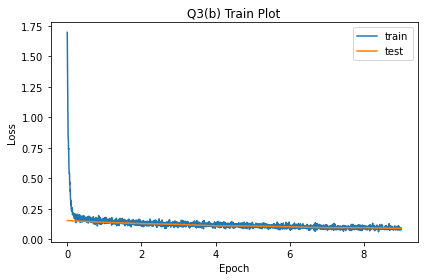

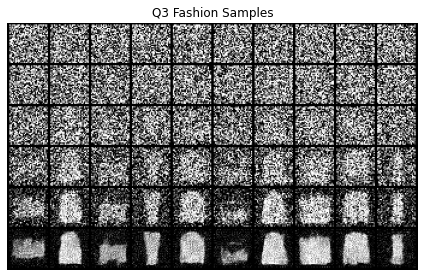

In [ ]:
bq3_save_results('b', q3_b)